# Covid 19 Analysis

In [10]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [11]:
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

def train_model(params, search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    print('Best score: {}'.format(search.best_score_))
    print('Best parameters: {}'.format(search.best_params_))
    return search.best_estimator_

    #rf_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                          #max_depth=100, max_features=3, max_leaf_nodes=None,
                          #max_samples=None, min_impurity_decrease=0.0,
                          #min_impurity_split=None, min_samples_leaf=3,
                          #min_samples_split=8, min_weight_fraction_leaf=0.0,
                          #n_estimators=100, n_jobs=None, oob_score=False,
                          #random_state=None, verbose=0, warm_start=False)
    #rf_estimator.fit(in_conf_train, out_conf_train)
    #return rf_estimator
    
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()
    
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
def plot_pred_diff(df, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = rf_estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()


## 3) Prediction and Regression
### 3.1) Random Forest
- - -

In [12]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


#### 3.1.1) Regression for Confirmed Cases
- - -

In [14]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [5]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42])

In [6]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [7]:
# create Random Forest Regressor instance, and check the hyper parameters
rf = RandomForestRegressor()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [256]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


Elapsed time: 1.9870644291241963mins
Best score: -16709504.213739956
Best parameters: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 80, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 243.91812656615858
MSE: 3251673.91569277
RMSE: 1803.2398386495263
R^2: 0.9979642704555611


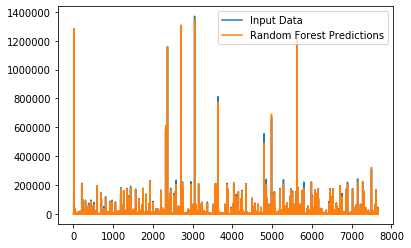

In [257]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

Text(0.5, 1.0, 'Average score: -1.0498921070008538')

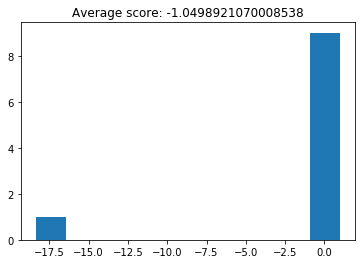

In [258]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

MAE: 12219.412175359113
MSE: 589611042.2241441
RMSE: 24281.907713854445
R^2: 0.9974587636783742


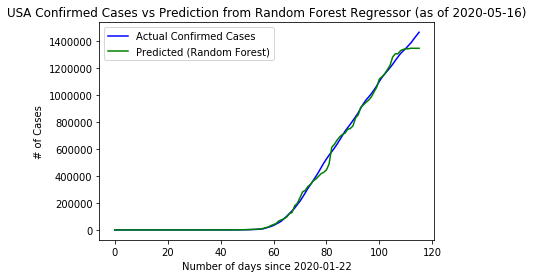

In [259]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "USA Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2693.4474418907425
MSE: 28379424.50338482
RMSE: 5327.234226442913
R^2: 0.9967227583321607


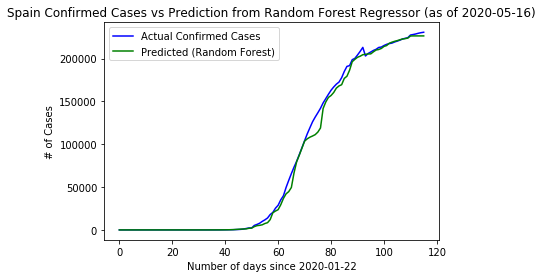

In [260]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2524.853883438156
MSE: 64985752.141007125
RMSE: 8061.374085167313
R^2: 0.9782340082871728


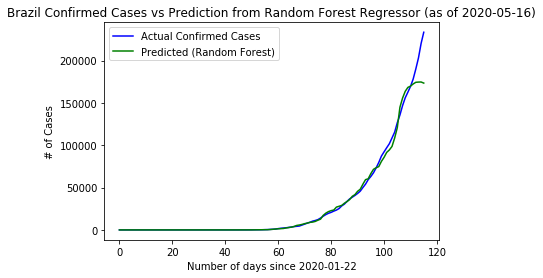

In [261]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 434.3682648741109
MSE: 602454.4804250252
RMSE: 776.1794125233065
R^2: 0.9947518646630428


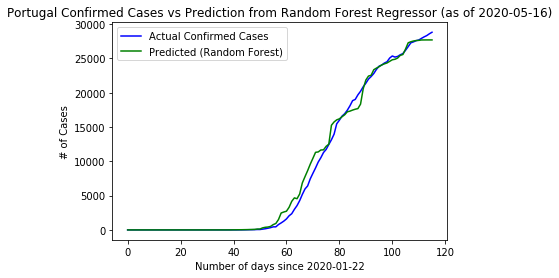

In [262]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"],
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor"
)

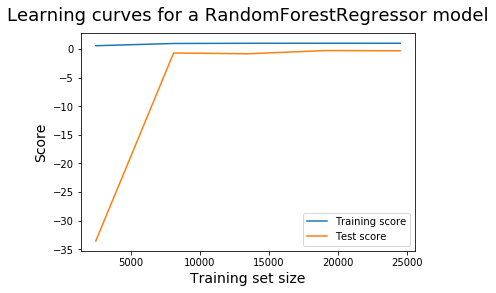

In [263]:
# learning curve
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# NON NORMALIZED

In [264]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [ ]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

In [265]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [266]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.0min finished


Elapsed time: 4.402002048492432mins
Best score: -19132469.020053256
Best parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 80, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 335.52562390199387
MSE: 12923625.47436782
RMSE: 3594.9444327232404
R^2: 0.994754068703177


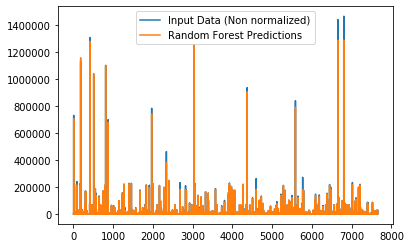

In [267]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

Text(0.5, 1.0, 'Average score: -1.0903860305112003')

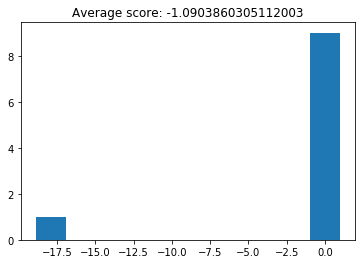

In [268]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

MAE: 15087.44043640843
MSE: 1107413051.5423048
RMSE: 33277.81620753238
R^2: 0.9952270258389224


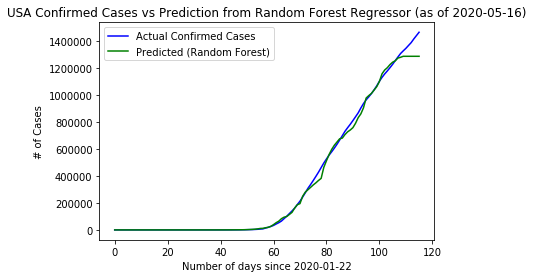

In [269]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2568.4919768152326
MSE: 22659555.318530012
RMSE: 4760.205386170855
R^2: 0.9973832859487429


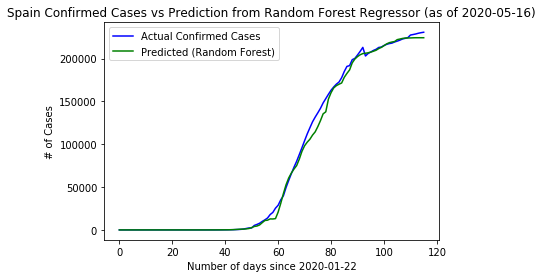

In [270]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)",
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor"
)

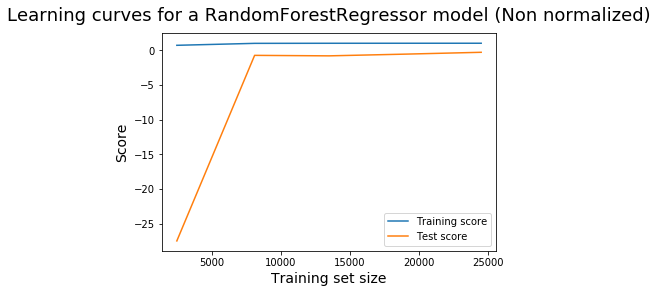

In [271]:
# learning curve
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# USING INCREMENTS AS OUTPUT

In [272]:
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [273]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [274]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [275]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


Elapsed time: 2.5904807686805724mins
Best score: -97521.80065111232
Best parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 100, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 35.88707886006047
MSE: 79284.57698960845
RMSE: 281.57517111707216
R^2: 0.9439484638750829


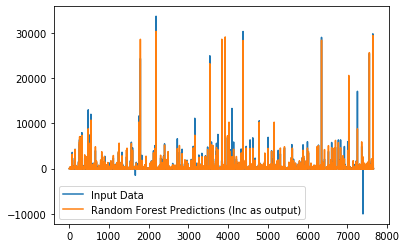

In [276]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

Text(0.5, 1.0, 'Average score: 0.4278780200327345')

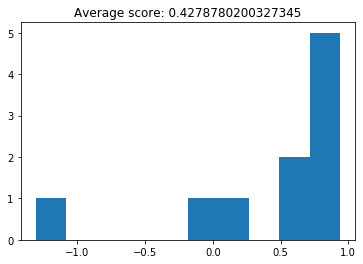

In [277]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

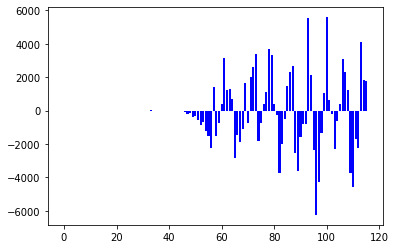

In [278]:
plot_pred_diff(
    df, "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed_inc"
)

MAE: 2691.3294756123178
MSE: 17205875.415853344
RMSE: 4147.996554464979
R^2: 0.9999258423054846


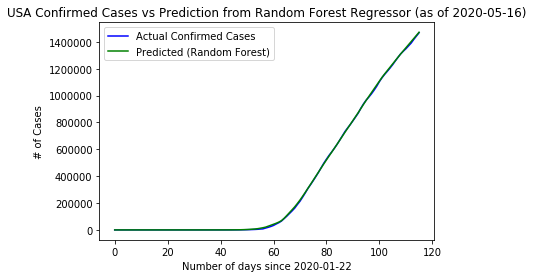

In [279]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 4135.852499372679
MSE: 44485003.61415797
RMSE: 6669.7079107077825
R^2: 0.9948628941569654


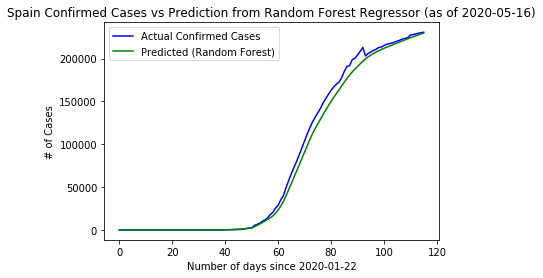

In [280]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 1126.470662109067
MSE: 9410182.20555671
RMSE: 3067.6020285487994
R^2: 0.9968482022419635


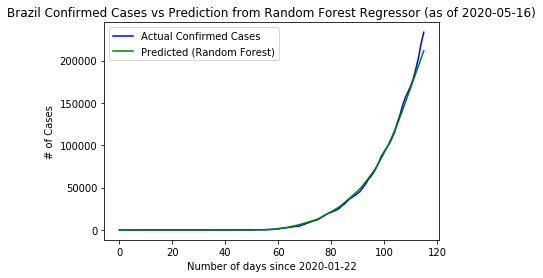

In [281]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

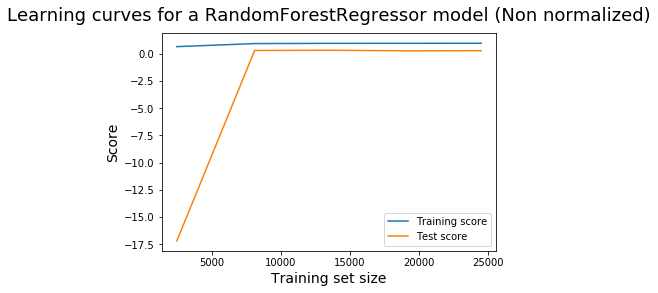

In [282]:
# learning curve
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# INCREASES AS INPUTS AND CUMULATIVE AS OUTPUT

In [283]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [284]:
outputs = new_df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42], dtype=int64)

In [285]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [286]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


Elapsed time: 2.5981010675430296mins
Best score: -135183010.27057955
Best parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 110, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=110, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 844.3359484201126
MSE: 164036697.59402975
RMSE: 12807.681195049701
R^2: 0.8964459455953864


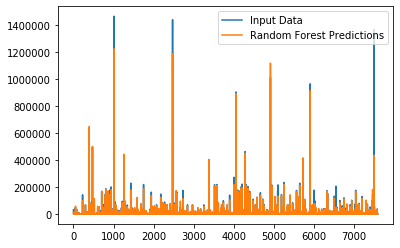

In [287]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

Text(0.5, 1.0, 'Average score: -5.23041058320168')

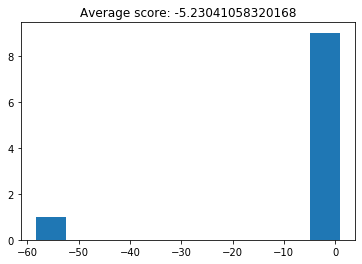

In [288]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

MAE: 41169.724280796036
MSE: 12955343903.341518
RMSE: 113821.54410893185
R^2: 0.944380205132981


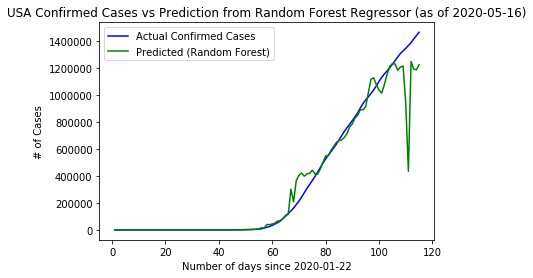

In [289]:
plot_predictions_for_country(
    new_df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 9979.64097788509
MSE: 616209787.3223575
RMSE: 24823.573218260855
R^2: 0.9289700870233434


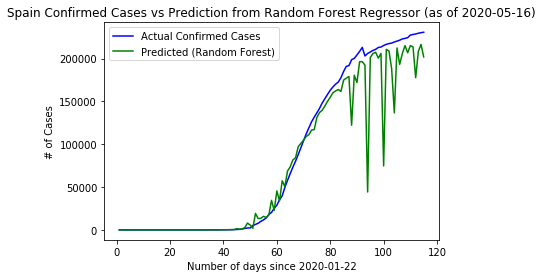

In [290]:
plot_predictions_for_country(
    new_df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    new_df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    new_df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    new_df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
plot_predictions_for_country(
    new_df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor"
)

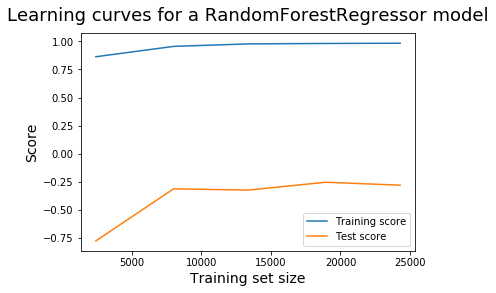

In [291]:
# learning curve
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# INCREASES AS INPUTS AND INCREASES AS OUTPUT

In [292]:
inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [293]:
outputs = new_df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [294]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [295]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


Elapsed time: 2.176396099726359mins
Best score: -98148.69540077799
Best parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 80, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 39.59033568735114
MSE: 113749.33025804073
RMSE: 337.26744618780026
R^2: 0.9258685682715283


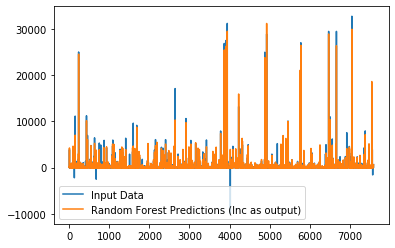

In [296]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

Text(0.5, 1.0, 'Average score: 0.5289056151680082')

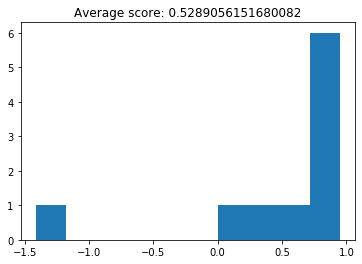

In [297]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

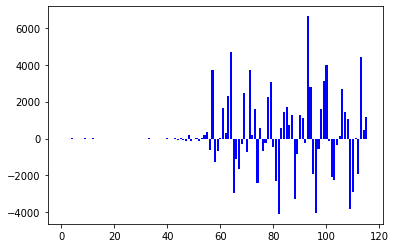

In [298]:
plot_pred_diff(
    new_df, "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

MAE: 6339.05733628085
MSE: 96005078.00495474
RMSE: 9798.218103561216
R^2: 0.9995878316481085


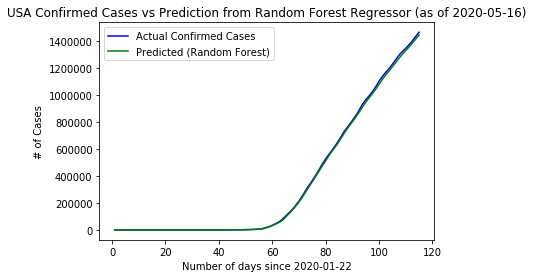

In [299]:
plot_predictions_for_country(
    new_df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 4073.170148770387
MSE: 46777487.85406443
RMSE: 6839.406981169086
R^2: 0.9946080037027996


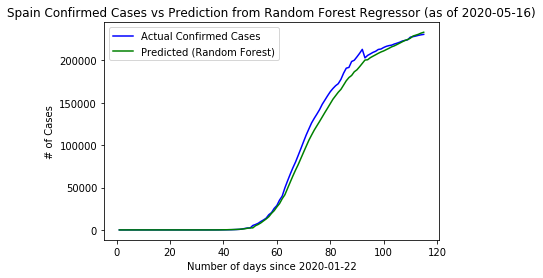

In [300]:
plot_predictions_for_country(
    new_df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

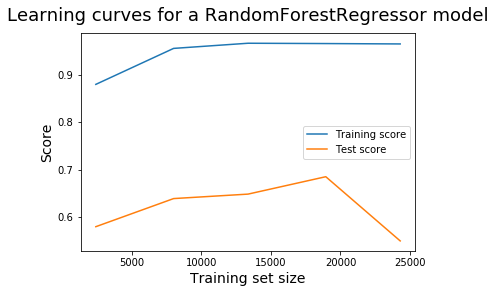

In [301]:
# learning curve
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# INCREASES AS OUTPUT, NON NORMALIZED INPUTS

In [302]:
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [303]:
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [304]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [305]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Elapsed time: 1.1342957854270934mins
Best score: -76405.82463859017
Best parameters: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 80, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 36.593889661402706
MSE: 116831.85300594705
RMSE: 341.8067480403906
R^2: 0.9501443689511697


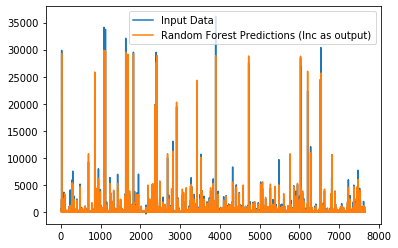

In [306]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

Text(0.5, 1.0, 'Average score: 0.38636511704500937')

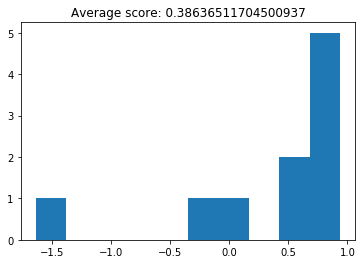

In [307]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

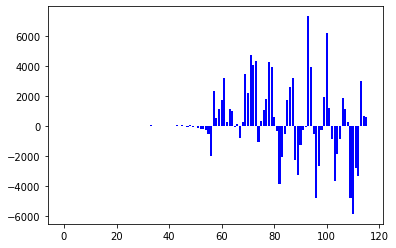

In [308]:
plot_pred_diff(
    df, "US", 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

MAE: 13361.867515008697
MSE: 427698455.64395535
RMSE: 20680.871733173033
R^2: 0.9981566104222103


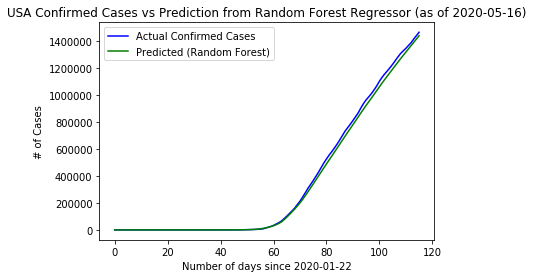

In [309]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 6873.229700301702
MSE: 101847639.01144159
RMSE: 10091.959126524522
R^2: 0.9882386858725928


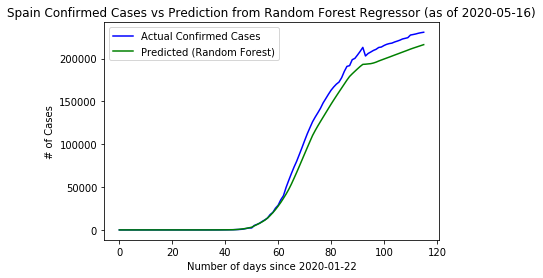

In [310]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 6873.229700301702
MSE: 101847639.01144159
RMSE: 10091.959126524522
R^2: 0.9882386858725928


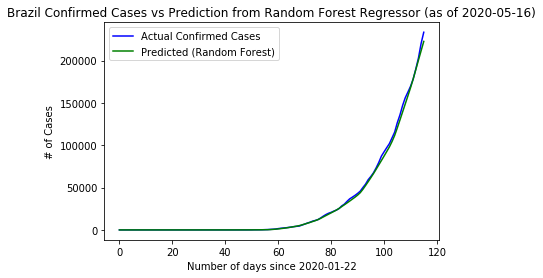

In [311]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

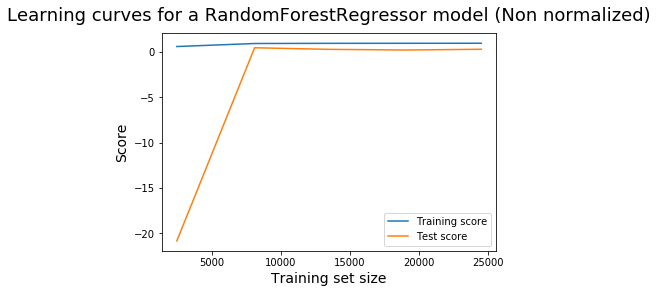

In [312]:
# learning curve
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.2) Regression for Death Cases
- - -

**(Will only use Increases as output and normalized inputs, as this approach got the best results)**

In [313]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [314]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Deaths_inc"].values
outputs

array([0., 0., 0., ..., 0., 0., 0.])

In [315]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [316]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished


Elapsed time: 2.0456465323766073mins
Best score: -682.390222521817
Best parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 90, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 2.8562059668913715
MSE: 791.5396299594858
RMSE: 28.134314101457775
R^2: 0.866279494696828


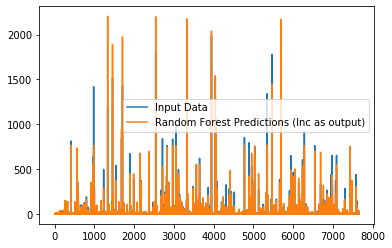

In [317]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

Text(0.5, 1.0, 'Average score: 0.4666500222788635')

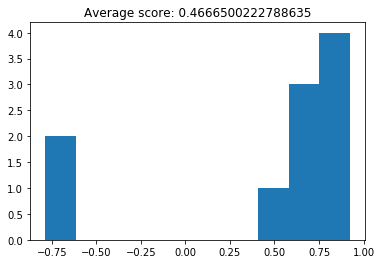

In [318]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

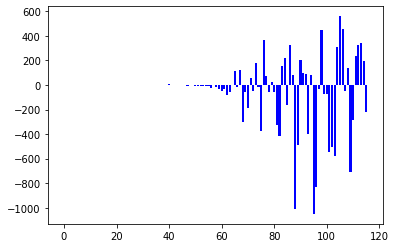

In [319]:
plot_pred_diff(
    df, "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths_inc"
)

MAE: 1018.6751734709745
MSE: 3558840.3673498644
RMSE: 1886.4888993444579
R^2: 0.9956475925638582


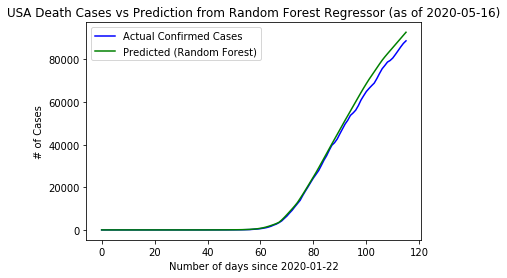

In [320]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Death Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 457.56557604714743
MSE: 488532.47678276285
RMSE: 698.9509831045114
R^2: 0.9956170507930713


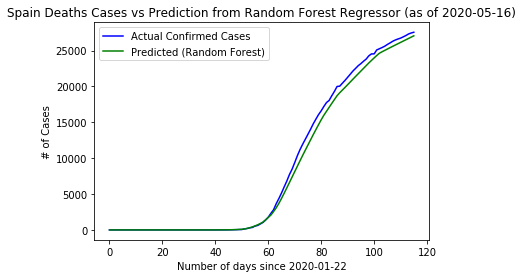

In [321]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Death Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 51.28889936583239
MSE: 10199.086337604469
RMSE: 100.9905259794426
R^2: 0.9992770398378373


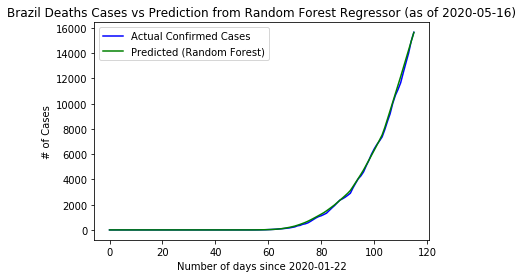

In [322]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Death Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Death Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 18.867489203484308
MSE: 982.2828567740685
RMSE: 31.34139206822295
R^2: 0.9976121384822946


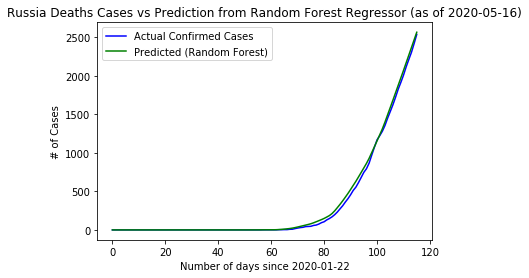

In [323]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Death Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Death Cases vs Prediction from Random Forest Regressor",
    True
)

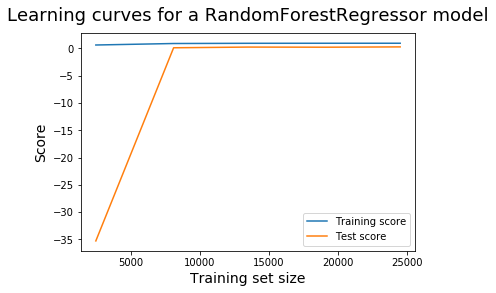

In [324]:
# learning curve
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.3) Regression for Recovered Cases
- - -

**(Will only use Increases as output and normalized inputs, as this approach got the best results)**

In [325]:
recovered_df = df.loc[df["Recovered"].notna()]

In [326]:
# get the inputs of the data for the machine learning algorithm
inputs = recovered_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 0.27177561, -0.30283255, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [327]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = recovered_df["Recovered_inc"].values
outputs

array([ 0.,  0.,  0., ..., 59.,  0.,  0.])

In [328]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [329]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


Elapsed time: 1.654477596282959mins
Best score: -61423.84371786736
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 100, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 32.82917178399843
MSE: 184113.23374027287
RMSE: 429.08418024936884
R^2: 0.48895822734232797


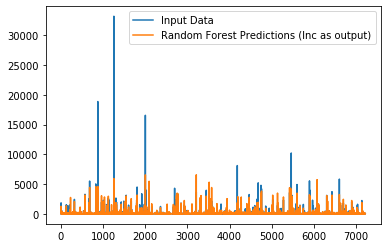

In [330]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

Text(0.5, 1.0, 'Average score: -1.8520121260478208')

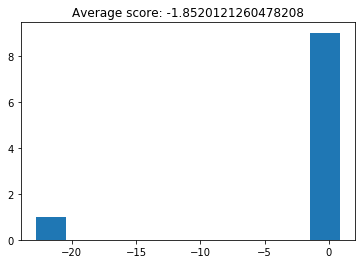

In [331]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

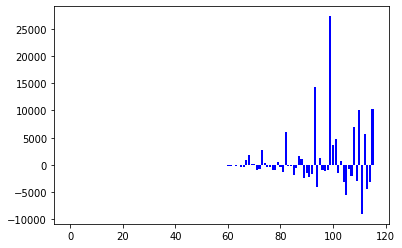

In [332]:
plot_pred_diff(
    recovered_df, "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered_inc"
)

MAE: 6239.914484293209
MSE: 200030612.5319352
RMSE: 14143.217898764595
R^2: 0.9641555326300537


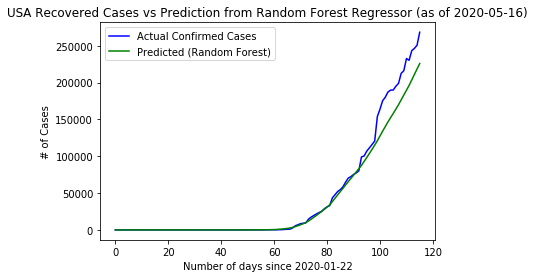

In [333]:
plot_predictions_for_country(
    recovered_df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 1600.3558595345692
MSE: 7367506.839991245
RMSE: 2714.3151696129994
R^2: 0.9969788299072244


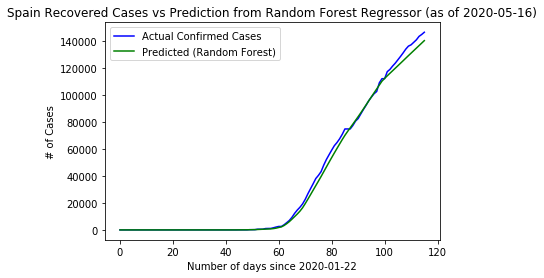

In [334]:
plot_predictions_for_country(
    recovered_df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 729.513880607775
MSE: 2562282.298799529
RMSE: 1600.713059483032
R^2: 0.9949074840640155


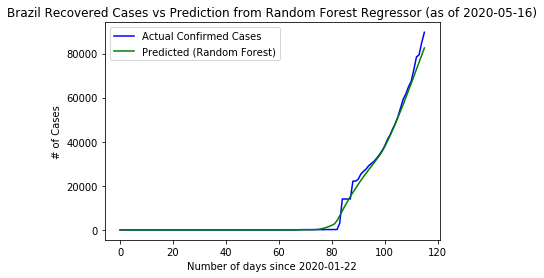

In [335]:
plot_predictions_for_country(
    recovered_df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    recovered_df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    recovered_df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
plot_predictions_for_country(
    recovered_df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

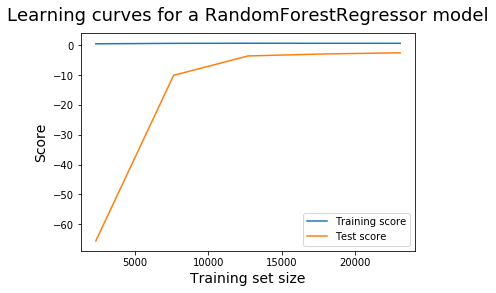

In [336]:
# learning curve
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

plot_learning_curve(rf_estimator_2, inputs, outputs)